### Исходные данные

* Клиент: Омега
* Категории: Потребительское кредитование
* Период для анализа: янв - авг 2020

### 0. Обзор и предобработка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


data = pd.read_excel('data.xlsx')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   11912 non-null  object        
 1   client_id                11912 non-null  int64         
 2   Month                    11912 non-null  datetime64[ns]
 3   Category                 11912 non-null  object        
 4   Device                   11912 non-null  object        
 5   Place                    11912 non-null  object        
 6   BannerType               11912 non-null  object        
 7   QueryType (search only)  11912 non-null  object        
 8   TargetingType            11912 non-null  object        
 9   Shows                    11912 non-null  int64         
 10  Clicks                   11912 non-null  int64         
 11  Cost_rub_wo_NDS          11912 non-null  float64       
 12  Conversions              11912 n

Пропуски в данных отсутствуют.

Описание столбцов таблицы:
* Client – название клиента
* client_id – идентификатор клиента
* Device – тип устройства
* Place – тип площадки
* BannerType – тип объявления
* QueryType – тип запроса (только для Place: Search)
* TargetingType – тип таргетинга
* Shows – Показы
* Clicks – Клики
* Cost_rub_wo_NDS – Расходы
* Conversions – Целевые визиты

In [3]:
data.head()

,Client,client_id,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost_rub_wo_NDS,Conversions
0,Бета,234679,2020-07-01,ВКЛАДЫ,Desktop,Networks,cpc_video,none,Phrase,0,0,0.000000,0
1,Гамма,458303,2019-04-01,ДЕБЕТОВЫЕ КАРТЫ,Desktop,Networks,cpc_video,none,Phrase,76722,2002,19467.482339,3
2,Гамма,458303,2019-04-01,ДЕБЕТОВЫЕ КАРТЫ,Desktop,Networks,cpc_video,none,Retargeting,9260,116,2590.924703,0
3,Гамма,458303,2019-06-01,ДЕБЕТОВЫЕ КАРТЫ,Desktop,Networks,cpc_video,none,Retargeting,0,0,0.000000,0
4,Гамма,458303,2019-04-01,ДЕБЕТОВЫЕ КАРТЫ,Mobile,Networks,cpc_video,none,Phrase,27140,825,4181.504949,0


Проверка на наличие дублирующихся строк в датасете:

In [4]:
data.duplicated().sum()

0

In [5]:
pd.Series(data.Month.unique()).sort_values()

1    2019-04-01
7    2019-05-01
2    2019-06-01
3    2019-07-01
4    2019-08-01
9    2019-09-01
5    2019-10-01
6    2019-11-01
14   2019-12-01
15   2020-01-01
8    2020-02-01
16   2020-03-01
17   2020-04-01
10   2020-05-01
11   2020-06-01
0    2020-07-01
12   2020-08-01
13   2020-09-01
dtype: datetime64[ns]

В задании указан период для анализа: январь - август 2020 г. Отфильтруем данные для данных месяцев:

In [6]:
df = data[(data.Month >= '2020-01-01') & (data.Month <= '2020-08-01')]

Также в задании указана категория для анализа: Потребительское кредитование. Отфильтруем данные:

In [7]:
df = df[df.Category == 'ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ']

Типы площадок:
* Networks - РСЯ (рекламная сеть Яндекса)
* Search - поисковые системы 

In [8]:
df.Place.unique()

array(['Networks', 'Search'], dtype=object)

Тип запроса (только для Place: Search):
* Competitor - запросы с упоминанием конкурентов
* Brand - брендовые запросы
* Other - другие

In [9]:
df['QueryType (search only)'].unique()

array(['none', 'Brand', 'Competitor', 'Other'], dtype=object)

Типы устройств:
* Desktop - ПК
* Mobile - мобильные устройства

In [10]:
df.Device.unique()

array(['Desktop', 'Mobile'], dtype=object)

Типы объявлений:
* cpc_video - видео-объявления с оплатой за клик
* dynamic - динамические объявления
* image_ad - графические объявления
* mcbanner - баннер на поиске
* perfomance - 
* text - текстовые объявления
* cmp_banner - смарт-баннер

In [11]:
df.BannerType.unique()

array(['cpc_video', 'image_ad', 'mcbanner', 'performance', 'text',
       'cpm_banner'], dtype=object)

Типы значений в столбце TargetingType (Тип Таргетинга):
* Phrase - ключевая фраза
* Retargeting - ретаргетинг
* Autotargeting - автотаретинг

In [12]:
df.TargetingType.unique()

array(['Phrase', 'Retargeting', 'Autotargeting'], dtype=object)

Список клиентов для анализа:

In [13]:
clients = df.Client.unique()

In [14]:
clients

array(['Бета', 'Гамма', 'Сигма', 'Альфа', 'Омега', 'Лямбда', 'Зета',
       'Мета', 'Псилон'], dtype=object)

### 1) оценить текущее положение клиента относительно конкурентов в категории (сравнительный анализ эффективности затрат)

Так как из данных у нас есть только сведения о количестве целевых визитов, но отсутствуют данные о полученной прибыли и конверсии визитов в дальнейшие действия, то будем сравнивать положение клиента по величине расхода на 1 целевой визит в разрезе категорий/площадок/устройств

### Количество конверсий

In [15]:
tmp_df = df.groupby('Client').Conversions.sum()
tmp_df

Client
Альфа      56491
Бета      190431
Гамма     109778
Зета       20151
Лямбда    221762
Мета      141441
Омега      70183
Псилон     54910
Сигма     229930
Name: Conversions, dtype: int64

<AxesSubplot:ylabel='Conversions'>

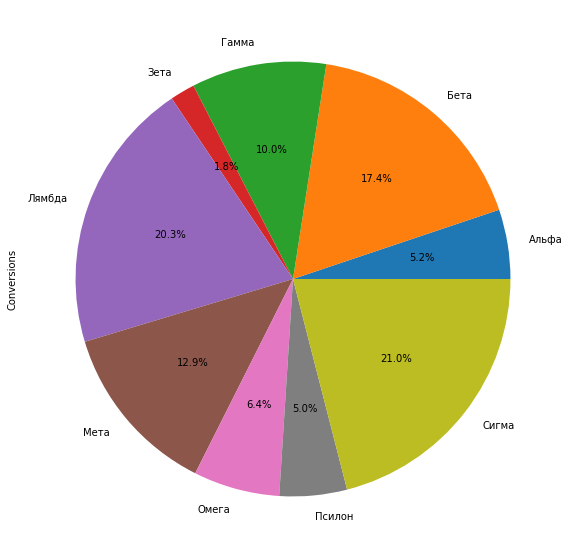

In [16]:
plt.figure(figsize=(10, 10))
tmp_df.plot.pie(autopct="%.1f%%")

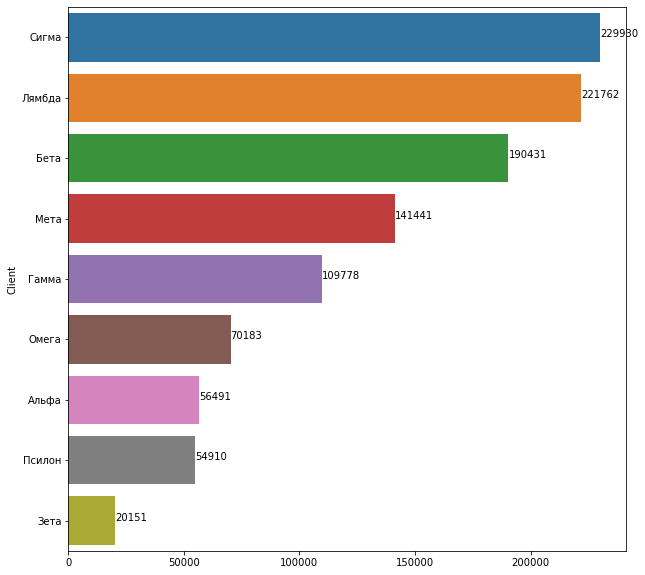

In [17]:
tmp_df = tmp_df.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
g = sns.barplot(y=tmp_df.index, x=tmp_df.values)

i = 0
for row in tmp_df:
    g.text(row, i, row, color='black', ha="left")
    i += 1

### Средняя цена целевого визита

In [18]:
tmp_df = df.groupby('Client').agg({'Conversions':'sum', 'Cost_rub_wo_NDS': 'sum'})
tmp_df['CPA'] = (tmp_df.iloc[:, 1] / tmp_df.iloc[:, 0]).round(2)

In [19]:
tmp_df

,Conversions,Cost_rub_wo_NDS,CPA
Client,,,
Альфа,56491,3.515006e+07,622.22
Бета,190431,1.240412e+08,651.37
Гамма,109778,2.858804e+07,260.42
Зета,20151,3.490289e+07,1732.07
Лямбда,221762,5.937816e+07,267.76
Мета,141441,2.198198e+07,155.41
Омега,70183,2.979191e+07,424.49
Псилон,54910,3.757908e+07,684.38
Сигма,229930,5.956512e+07,259.06


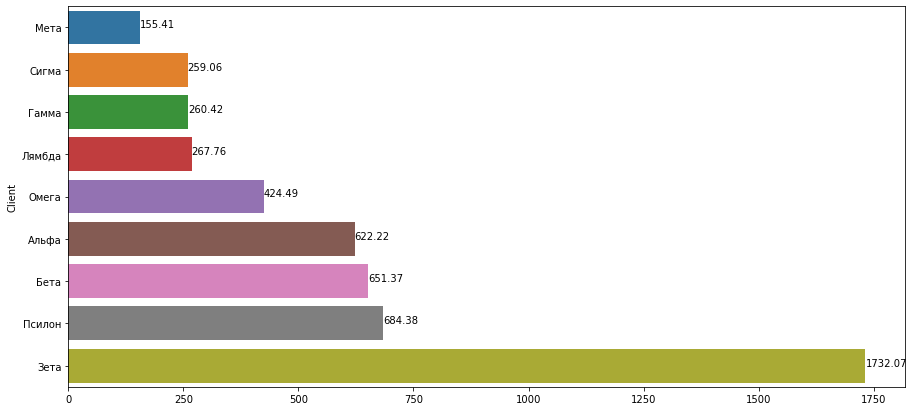

In [20]:
tmp_df = tmp_df.sort_values('CPA')
plt.figure(figsize=(15, 7))
g = sns.barplot(y=tmp_df.index, x=tmp_df.CPA.values)

i = 0
for idx, row in tmp_df.iterrows():
    g.text(row.CPA, i, round(row.CPA, 2), color='black', ha="left")
    i += 1

### Тип устройства

In [21]:
tmp_df = df.groupby(['Client', 'Device'], as_index=False).sum()
tmp_df['total_conversions'] = tmp_df['Client'].map(tmp_df.groupby('Client').Conversions.sum())
tmp_df['total_cost'] = tmp_df['Client'].map(tmp_df.groupby('Client').Cost_rub_wo_NDS.sum())
tmp_df['proportion_conversions'] = round(tmp_df['Conversions'] / tmp_df['total_conversions'] * 100, 2)
tmp_df['proportion_cost'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['total_cost'] * 100, 2)
tmp_df['CPA'] = tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions']

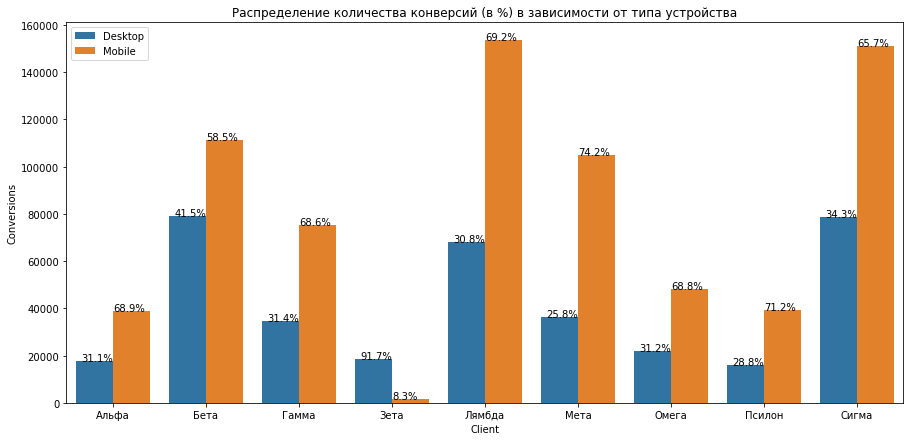

In [22]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='Conversions', x='Client', hue='Device')
plt.legend(loc=2)
plt.title('Распределение количества конверсий (в %) в зависимости от типа устройства')
for idx, row in tmp_df.iterrows():
    if idx % 2 == 0:
        g.text(idx // 2, row.Conversions, f"{round(row.proportion_conversions, 1)}%", color='black', ha="right")
    else:
        g.text(idx // 2, row.Conversions, f"{round(row.proportion_conversions, 1)}%", color='black', ha="left")

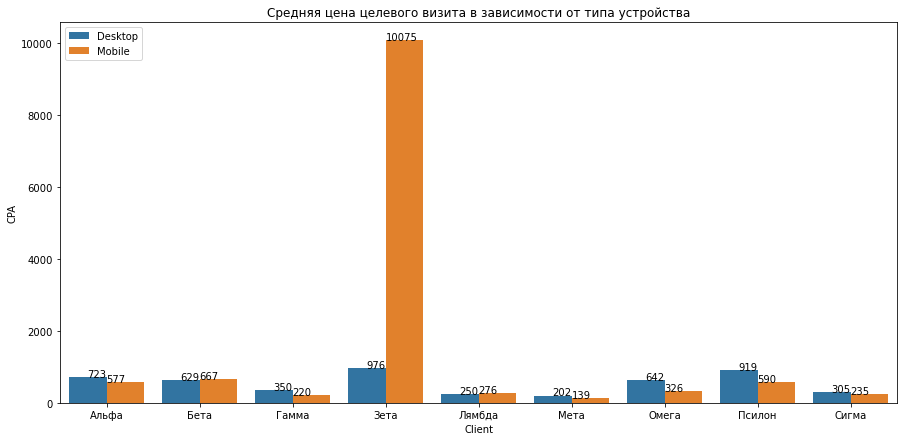

In [23]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CPA', x='Client', hue='Device')
plt.legend(loc=2)
plt.title('Средняя цена целевого визита в зависимости от типа устройства')
for idx, row in tmp_df.iterrows():
    if idx % 2 == 0:
        g.text(idx // 2, row.CPA, round(row.CPA), color='black', ha="right")
    else:
        g.text(idx // 2, row.CPA, round(row.CPA), color='black', ha="left")

### Тип площадки

In [24]:
tmp_df = df.groupby(['Client', 'Place'], as_index=False).sum()
tmp_df['total_conversions'] = tmp_df['Client'].map(tmp_df.groupby('Client').Conversions.sum())
tmp_df['total_cost'] = tmp_df['Client'].map(tmp_df.groupby('Client').Cost_rub_wo_NDS.sum())
tmp_df['proportion_conversions'] = round(tmp_df['Conversions'] / tmp_df['total_conversions'] * 100, 2)
tmp_df['proportion_cost'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['total_cost'] * 100, 2)
tmp_df['CPA'] = tmp_df.apply(lambda x: x['Cost_rub_wo_NDS'] / x['Conversions'] if x['Conversions'] !=0 else 0, axis=1)

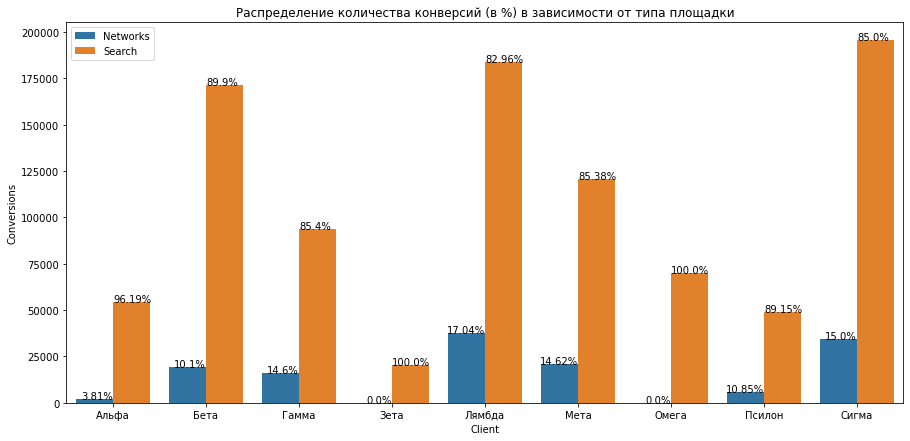

In [25]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='Conversions', x='Client', hue='Place')
plt.legend(loc=2)
plt.title('Распределение количества конверсий (в %) в зависимости от типа площадки')
for idx, row in tmp_df.iterrows():
    if idx % 2 == 0:
        g.text(idx // 2, row.Conversions, f"{round(row.proportion_conversions, 2)}%", color='black', ha="right")
    else:
        g.text(idx // 2, row.Conversions, f"{round(row.proportion_conversions, 2)}%", color='black', ha="left")

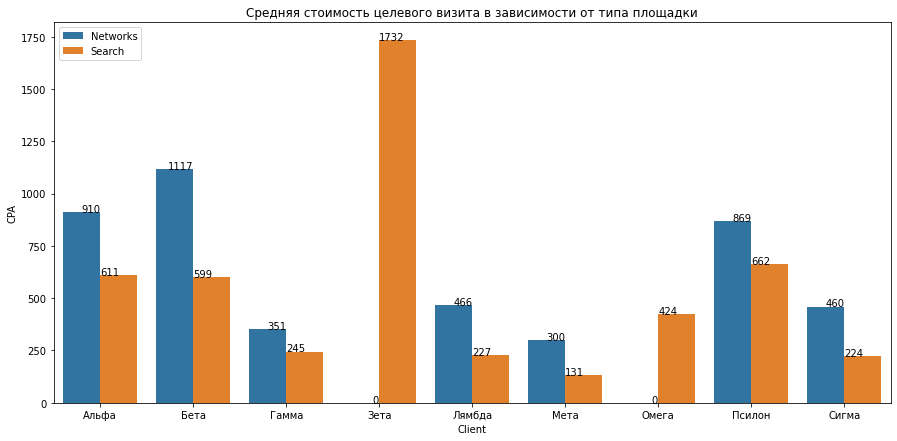

In [26]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CPA', x='Client', hue='Place')
plt.legend(loc=2)
plt.title('Средняя стоимость целевого визита в зависимости от типа площадки')
for idx, row in tmp_df.iterrows():
    if idx % 2 == 0:
        g.text(idx // 2, row.CPA, round(row.CPA), color='black', ha="right")
    else:
        g.text(idx // 2, row.CPA, round(row.CPA), color='black', ha="left")

### Тип запроса

In [27]:
tmp_df = df[df.Place == 'Search'].groupby(['Client', 'QueryType (search only)'], as_index=False).sum()
tmp_df['total_conversions'] = tmp_df['Client'].map(tmp_df.groupby('Client').Conversions.sum())
tmp_df['proportion_conversions'] = round(tmp_df['Conversions'] / tmp_df['total_conversions'] * 100, 2)
tmp_df['CPA'] = tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions']

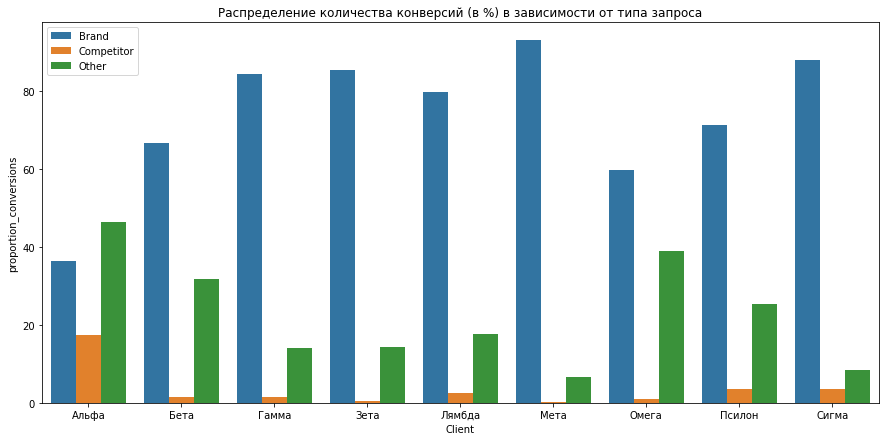

In [28]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='proportion_conversions', x='Client', hue='QueryType (search only)')
plt.legend(loc='best')
plt.title('Распределение количества конверсий (в %) в зависимости от типа запроса');

In [29]:
tmp_df[tmp_df.Client == 'Омега']

,Client,QueryType (search only),client_id,Shows,Clicks,Cost_rub_wo_NDS,Conversions,total_conversions,proportion_conversions,CPA
18,Омега,Brand,5333568,2205282,422599,1.369857e+07,42029,70182,59.89,325.931306
19,Омега,Competitor,5666916,163152,9662,6.438127e+05,775,70182,1.10,830.726038
20,Омега,Other,6000264,1866220,210954,1.544953e+07,27378,70182,39.01,564.304700


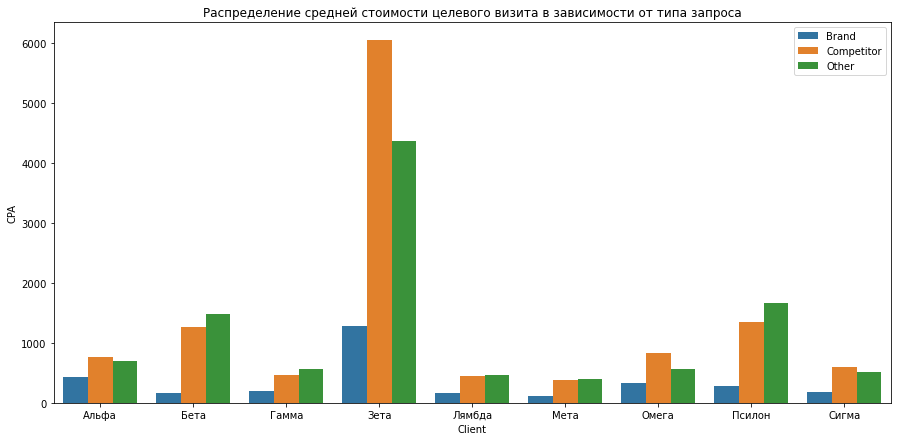

In [30]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CPA', x='Client', hue='QueryType (search only)')
plt.legend(loc='best')
plt.title('Распределение средней стоимости целевого визита в зависимости от типа запроса');

### Тип объявления

In [31]:
tmp_df = df.groupby(['Client', 'BannerType'], as_index=False).sum()
tmp_df['total_conversions'] = tmp_df['Client'].map(tmp_df.groupby('Client').Conversions.sum())
tmp_df['total_cost'] = tmp_df['Client'].map(tmp_df.groupby('Client').Cost_rub_wo_NDS.sum())
tmp_df['proportion_conversions'] = round(tmp_df['Conversions'] / tmp_df['total_conversions'] * 100, 2)
tmp_df['proportion_cost'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['total_cost'] * 100, 2)
tmp_df['CPA'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions'], 2)

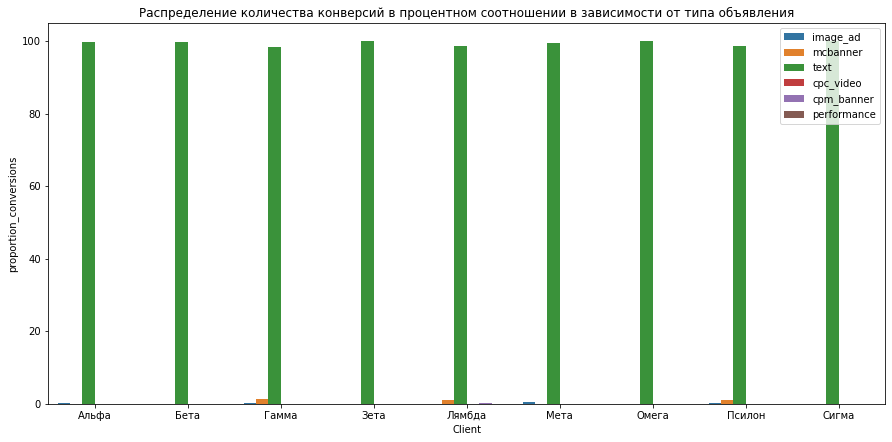

In [32]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='proportion_conversions', x='Client', hue='BannerType')
plt.legend(loc='best')
plt.title('Распределение количества конверсий в процентном соотношении в зависимости от типа объявления');

In [33]:
tmp_df[tmp_df.Client == 'Омега']

,Client,BannerType,client_id,Shows,Clicks,Cost_rub_wo_NDS,Conversions,total_conversions,total_cost,proportion_conversions,proportion_cost,CPA
21,Омега,cpm_banner,4666872,0,0,0.000000e+00,0,70183,2.979191e+07,0.0,0.0,NaN
22,Омега,image_ad,333348,0,0,0.000000e+00,0,70183,2.979191e+07,0.0,0.0,NaN
23,Омега,text,23667708,4234654,643215,2.979191e+07,70183,70183,2.979191e+07,100.0,100.0,424.49


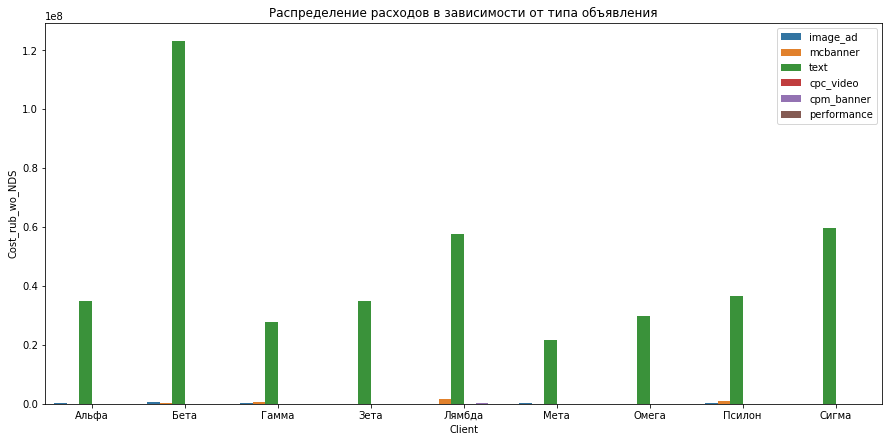

In [34]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='Cost_rub_wo_NDS', x='Client', hue='BannerType')
plt.legend(loc='best')
plt.title('Распределение расходов в зависимости от типа объявления');

### Тип таргетинга

In [35]:
tmp_df = df.groupby(['Client', 'TargetingType'], as_index=False).sum()
tmp_df['total_conversions'] = tmp_df['Client'].map(tmp_df.groupby('Client').Conversions.sum())
tmp_df['total_cost'] = tmp_df['Client'].map(tmp_df.groupby('Client').Cost_rub_wo_NDS.sum())
tmp_df['proportion_conversions'] = round(tmp_df['Conversions'] / tmp_df['total_conversions'] * 100, 2)
tmp_df['proportion_cost'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['total_cost'] * 100, 2)
tmp_df['CPA'] = tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions']

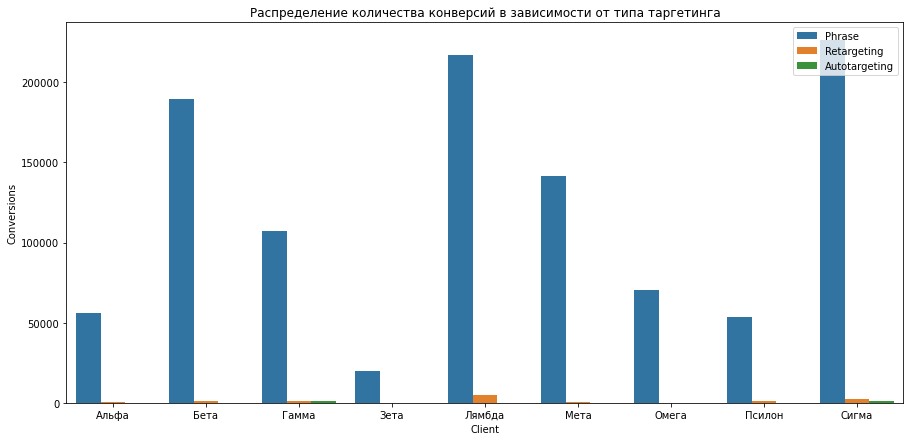

In [36]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='Conversions', x='Client', hue='TargetingType')
plt.legend(loc='best')
plt.title('Распределение количества конверсий в зависимости от типа таргетинга');

In [37]:
tmp_df[tmp_df.Client == 'Омега']

,Client,TargetingType,client_id,Shows,Clicks,Cost_rub_wo_NDS,Conversions,total_conversions,total_cost,proportion_conversions,proportion_cost,CPA
17,Омега,Autotargeting,1000044,0,0,0.000000e+00,0,70183,2.979191e+07,0.0,0.0,NaN
18,Омега,Phrase,19334184,4234654,643215,2.979191e+07,70182,70183,2.979191e+07,100.0,100.0,424.495079
19,Омега,Retargeting,8333700,0,0,0.000000e+00,1,70183,2.979191e+07,0.0,0.0,0.000000


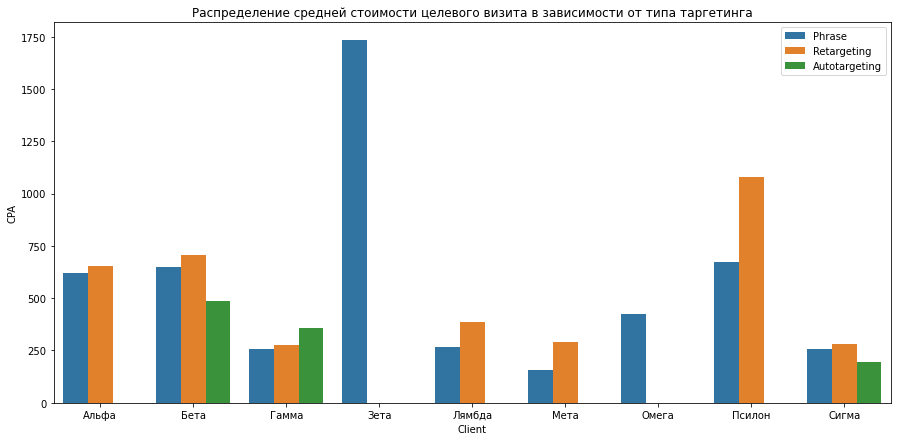

In [38]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CPA', x='Client', hue='TargetingType')
plt.legend(loc='best')
plt.title('Распределение средней стоимости целевого визита в зависимости от типа таргетинга');

### CTR объявлений и стоимость клика (CPC)

Сразу стоит заметить, что CTR для Поиска и для сетей существенно отличается. В рекламе на Поиске как правило гораздо меньшее число показов (пользователь вбивает запрос и видит сразу рекламу), а в сетях объявление может показываться сколько угодно раз, из-за чего CTR там существенно ниже, но и стоимость клика тоже ниже, так как основная конкуренция идет за горячих клиентов (которые ищут прямо сейчас) на Поиске.

In [39]:
tmp_df = df.groupby(['Place', 'TargetingType'], as_index=False).sum()
tmp_df['CTR'] = round(tmp_df['Clicks'] / tmp_df['Shows'] * 100, 2)
tmp_df['CPC'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Clicks'], 2)
tmp_df['CPA'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions'])

In [40]:
tmp_df

,Place,TargetingType,client_id,Shows,Clicks,Cost_rub_wo_NDS,Conversions,CTR,CPC,CPA
0,Networks,Autotargeting,5747456,159048,468,8.174453e+03,18,0.29,17.47,454.0
1,Networks,Phrase,104627574,1576233173,5250969,6.857275e+07,124918,0.33,13.06,549.0
2,Networks,Retargeting,98389031,87155103,360664,5.334577e+06,11377,0.41,14.79,469.0
3,Search,Autotargeting,26065636,459713,30200,7.540294e+05,2682,6.57,24.97,281.0
4,Search,Phrase,248447312,55324362,9041651,3.563089e+08,956082,16.34,39.41,373.0


Что и требовалось доказать.

В связи с этим дальнейшее разбиение будет проводиться отдельно по каждому типу площадок:

#### Поиск (текстово-графические объявления) по ключевым фразам

In [41]:
tmp_df = df[(df.Place == 'Search') & (df.TargetingType == 'Phrase') & (df.BannerType == 'text')].groupby(['Client', 'QueryType (search only)'], as_index=False).sum()
tmp_df['CTR'] = round(tmp_df['Clicks'] / tmp_df['Shows'] * 100, 2)
tmp_df['CPC'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Clicks'], 2)

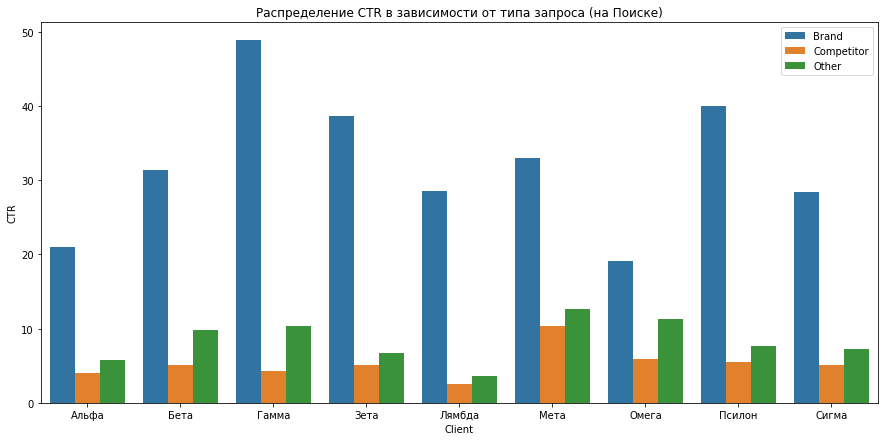

In [42]:
plt.figure(figsize=(15,7))
sns.barplot(data=tmp_df, y='CTR', x='Client', hue='QueryType (search only)')
plt.legend(loc=1)
plt.title('Распределение CTR в зависимости от типа запроса (на Поиске)')
plt.show();

In [43]:
tmp_df[tmp_df.Client == 'Омега']

,Client,QueryType (search only),client_id,Shows,Clicks,Cost_rub_wo_NDS,Conversions,CTR,CPC
18,Омега,Brand,5333568,2205282,422599,1.369857e+07,42029,19.16,32.42
19,Омега,Competitor,5333568,163152,9662,6.438127e+05,775,5.92,66.63
20,Омега,Other,5333568,1866220,210954,1.544953e+07,27378,11.30,73.24


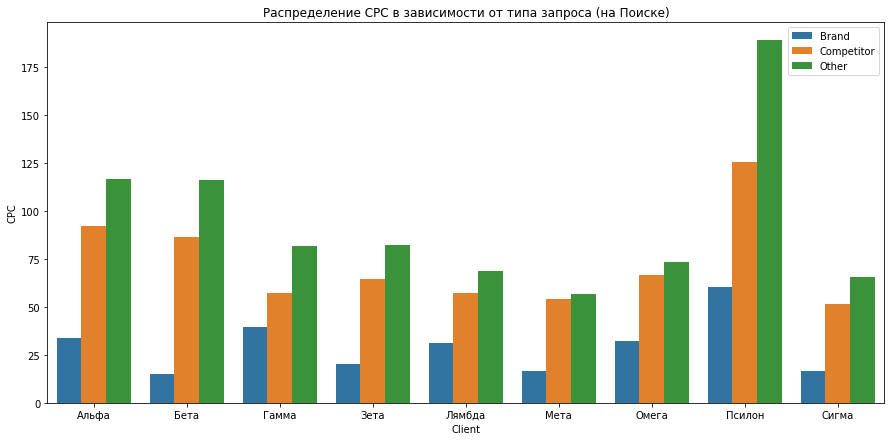

In [44]:
plt.figure(figsize=(15,7))
sns.barplot(data=tmp_df, y='CPC', x='Client', hue='QueryType (search only)')
plt.legend(loc=1)
plt.title('Распределение CPC в зависимости от типа запроса (на Поиске)')
plt.show();

#### Сети

In [45]:
tmp_df = df[df.Place == 'Networks'].groupby(['Client', 'TargetingType'], as_index=False).sum()
tmp_df['CTR'] = round(tmp_df['Clicks'] / tmp_df['Shows'] * 100, 2)
tmp_df['CPC'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Clicks'], 2)
tmp_df['CPA'] = round(tmp_df['Cost_rub_wo_NDS'] / tmp_df['Conversions'], 2)

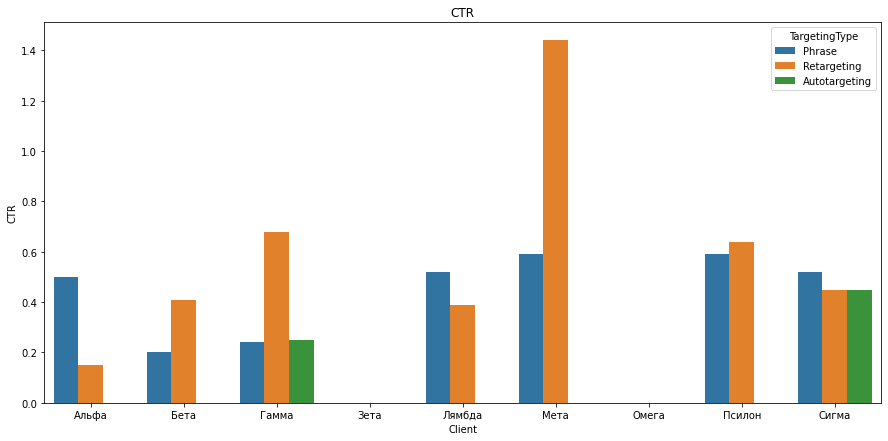

In [46]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CTR', x='Client', hue='TargetingType')
plt.title('CTR');

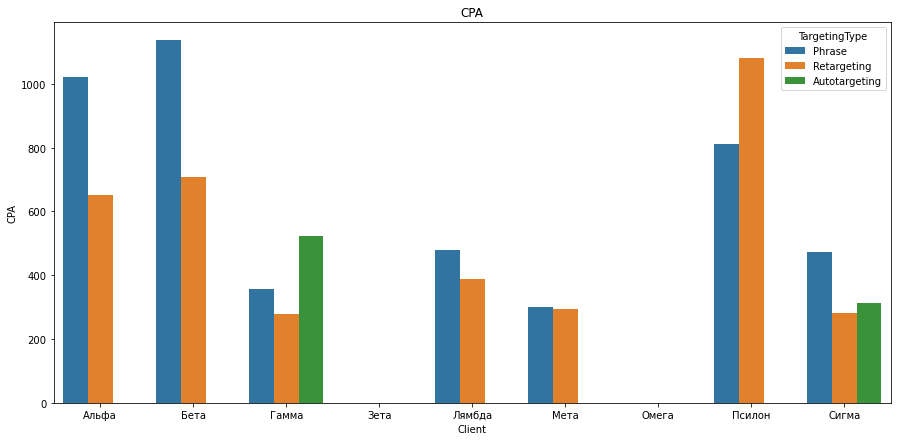

In [47]:
plt.figure(figsize=(15,7))
g = sns.barplot(data=tmp_df, y='CPA', x='Client', hue='TargetingType')
plt.title('CPA');